# Pose Estimation

In this notebook, we will explore OpenPose, a pose estimation library. OpenPose detects human body keypoints using single images.

https://github.com/CMU-Perceptual-Computing-Lab/openpose

It uses a multi-person pose estimation model. Given an input colour image, the model returns two outputs:
1. Confidence maps of body part locations ("keypoints")
2. Part affinity heatmaps for each keypoint pair ("associations" between body parts). 

![multipose](https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation/raw/master/readme/arch.png)

More details on the model are here: https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation

## Example Use Cases

Pose estimation models can be used in video pre-processing to extract poses for further analysis. For example, in this paper, the sequence of poses are fed into a Hidden Markov Model for predicting future poses. Other use cases are gaming, medical diagnosis, robotic control, driver assistant, etc (see: https://en.wikipedia.org/wiki/Articulated_body_pose_estimation)

![pose-dmm-dicta-17](assets/pose-dmm-dicta-17.png)

Source: Toyer et. al., Human Pose Forecasting via Deep Markov Models, 2017

### Other Solutions

https://github.com/facebookresearch/VideoPose3D

## Running OpenPose from the Command Line

We will be exploring the OpenPose Demo command line application to extract poses from a video file.

The poses will be saved to JSON.

### Setup (Windows only)

1. Download openpose-1.4.0-win64-cpu-binaries.zip from https://github.com/CMU-Perceptual-Computing-Lab/openpose/releases. 

2. Unzip the file

3. The pre-trained models are not included in the zip file because they are quite large. Download them:

```
cd openpose-1.4.0-win64-cpu-binaries\models

getModels.bat
```

The download should take about 5-10 minutes.

#### Non-Windows?

Unfortunately, installation for non-Windows involves building from source. To save time, you can partner with a classmate who has a Windows machine. 

Later, if you plan to do more work using OpenPose, you may wish to try these instructions at home (in your own time): https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/installation.md#openpose-from-other-projects-ubuntu-and-mac

### Run (Windows only)

1. [Important] run the demo from the top level openpose folder, not the subfolders:

```
cd openpose-1.4.0-win64-cpu-binaries

bin\OpenPoseDemo.exe --video examples\media\video.avi --part_candidates --write_json output
```

The above command runs the demo for face and hand keypoint detection, and writes the results as JSON format in a folder called `output`.


2. The video will run very slowly because this is the CPU version. 

Wait a few minutes to see keypoints appearing in the `output` folder.  There's no easy way to stop the demo. You should stop it after about 3-4 frames, because it consumes a lot of memory (use Ctrl+C).

If you have an NVidia GPU, you may want to try the GPU version (which run significantly faster and is recommended).

3. Other options are documented here:

```
bin\OpenPoseDemo.exe --video examples\media\video.avi --help
```

https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/demo_overview.md

## Exploring keypoints

The following section shows how to take the keypoints and plot them. 

For this section, we will use pre-extracted keypoint data in the HSS github repository, under the `data\openpose` folder.  This is the same set of keypoints extracted from the earlier video (but run from a GPU to speed things up).

The output format is documented here:
https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# requires: conda install opencv
import cv2

plt.style.use('seaborn-white')

In [2]:
# load the first frame
frame0 = json.load(open('./data/openpose/video_000000000000_keypoints.json', 'rb'))
frame0

{'version': 1.2,
 'people': [{'pose_keypoints_2d': [261.123,
    100.45,
    0.195454,
    272.751,
    125.865,
    0.863315,
    247.369,
    129.814,
    0.810691,
    243.408,
    164.99,
    0.75035,
    243.43,
    194.504,
    0.593861,
    290.487,
    120.042,
    0.873821,
    306.106,
    157.228,
    0.85622,
    311.977,
    190.498,
    0.794739,
    278.743,
    194.42,
    0.799748,
    266.955,
    194.527,
    0.783287,
    278.685,
    241.49,
    0.814345,
    302.228,
    264.994,
    0.784545,
    292.421,
    192.487,
    0.793043,
    302.153,
    241.403,
    0.787871,
    304.15,
    278.735,
    0.788785,
    259.12,
    98.4945,
    0.178321,
    266.946,
    96.448,
    0.176957,
    257.113,
    100.399,
    0.122823,
    274.855,
    96.4969,
    0.233078,
    296.305,
    290.45,
    0.692575,
    304.19,
    288.557,
    0.766012,
    304.261,
    284.55,
    0.596039,
    292.464,
    278.726,
    0.502732,
    290.45,
    276.758,
    0.539186,
    30

In [3]:
# count how many people
len(frame0['people'])

6

In [4]:
# what keypoints are logged for each person
frame0['people'][0].keys()

dict_keys(['pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])

In [5]:
# format is x1, y1, c1, x2, y2, c2, ...
# x, y coordinates with a confidence
frame0['people'][0]['pose_keypoints_2d']

[261.123,
 100.45,
 0.195454,
 272.751,
 125.865,
 0.863315,
 247.369,
 129.814,
 0.810691,
 243.408,
 164.99,
 0.75035,
 243.43,
 194.504,
 0.593861,
 290.487,
 120.042,
 0.873821,
 306.106,
 157.228,
 0.85622,
 311.977,
 190.498,
 0.794739,
 278.743,
 194.42,
 0.799748,
 266.955,
 194.527,
 0.783287,
 278.685,
 241.49,
 0.814345,
 302.228,
 264.994,
 0.784545,
 292.421,
 192.487,
 0.793043,
 302.153,
 241.403,
 0.787871,
 304.15,
 278.735,
 0.788785,
 259.12,
 98.4945,
 0.178321,
 266.946,
 96.448,
 0.176957,
 257.113,
 100.399,
 0.122823,
 274.855,
 96.4969,
 0.233078,
 296.305,
 290.45,
 0.692575,
 304.19,
 288.557,
 0.766012,
 304.261,
 284.55,
 0.596039,
 292.464,
 278.726,
 0.502732,
 290.45,
 276.758,
 0.539186,
 306.114,
 266.917,
 0.55395]

In [6]:
def keypoints_to_dataframe(keypoints):
    """Converts a flat keypoints list (x1, y1, c1, x2, y2, c2) into a pandas DataFrame"""
    return pd.DataFrame({'x': keypoints[::3], 'y': keypoints[1::3], 'c': keypoints[2::3]})

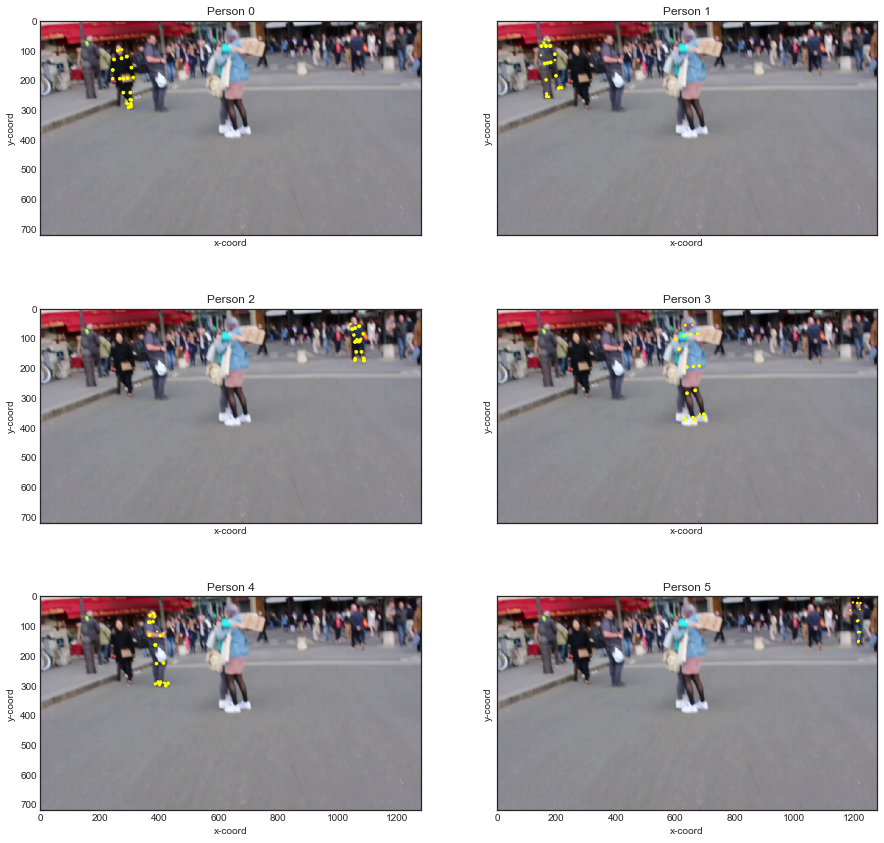

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
ax = ax.flatten()

video = cv2.VideoCapture('./data/openpose/video.avi')
_, image = video.read() # read the first frame

for i in range(len(frame0['people'])):
    df = keypoints_to_dataframe(frame0['people'][i]['pose_keypoints_2d'])
    
    # different size dots according to probability
    ax[i].scatter(df.x, df.y, s=df.c*10, color='yellow')
    ax[i].set(title=f'Person {i}', xlabel='x-coord', ylabel='y-coord')
    
    # openCV uses BGR, convert to RGB
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

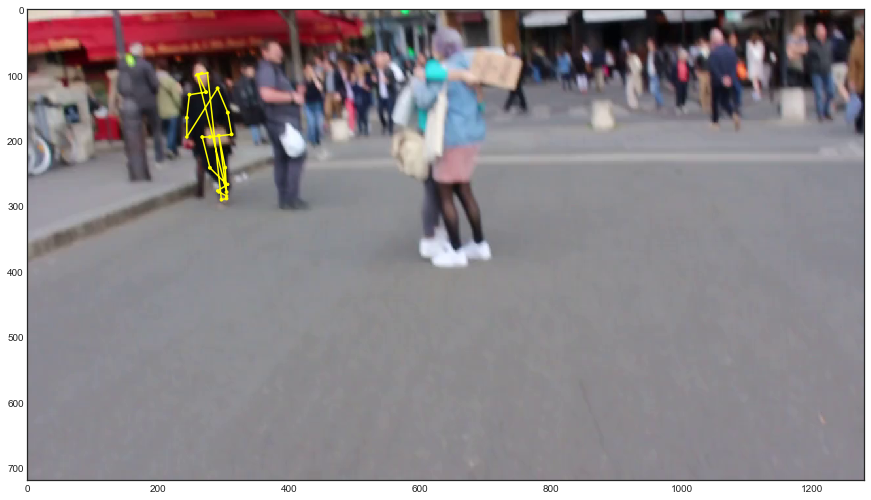

In [37]:

df = keypoints_to_dataframe(frame0['people'][0]['pose_keypoints_2d'])

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df.x, df.y, s=df.c*10, color='yellow')
ax.plot(df.x, df.y, color='yellow')

video = cv2.VideoCapture('./data/openpose/video.avi')
_, image = video.read()
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))